<a href="https://colab.research.google.com/github/louisestella/deepLearning/blob/main/Tarefa-05_IMDB-convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# constants and hyperparameters
MAX_WORD_INDEX = 10000

BATCH_SIZE = 128
NUM_EPOCHS = 10
LR = 0.001
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1.0e-8
DECAY = 0.0
VAL_PERC = 0.1

EMBEDDING_DIM = 64
NUM_LSTM_UNITS = 32
DROPOUT_RATE = 0.5

In [ ]:
# load database using Keras
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = MAX_WORD_INDEX)
X = np.concatenate((train_data, test_data), axis=0)
y = np.concatenate((train_labels, test_labels), axis=0)

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 2s 0us/step


In [ ]:
#  print some information on the data
max_seq_len_train = max([len(sequence) for sequence in train_data])
max_seq_len_test = max([len(sequence) for sequence in test_data])
min_seq_len_train = min([len(sequence) for sequence in train_data])
min_seq_len_test = min([len(sequence) for sequence in test_data])
print(f'Maximum train sequence length: {max_seq_len_train}')
print(f'Maximum test sequence length: {max_seq_len_test}')
print(f'Minimum train sequence length: {min_seq_len_train}')
print(f'Minimum test sequence length: {min_seq_len_test}')

Maximum train sequence length: 2494
Maximum test sequence length: 2315
Minimum train sequence length: 7
Minimum test sequence length: 11


In [ ]:
# randomly selects a sentence, look at the encoding and check its label
word_index = imdb.get_word_index()

ind = 33

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[ind]])

print(f'REVIEW:\n {decoded_review}\n')
print(f'Encoded sequence of words:\n {train_data[ind]}\n')
print(f'Label: {train_labels[ind]}\n')

1641221/1641221 [==============================] - 1s 1us/step
REVIEW:
 ? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything 

In [ ]:
# pad sequences
X_train = keras.preprocessing.sequence.pad_sequences(train_data)
X_test = keras.preprocessing.sequence.pad_sequences(test_data)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (40000, 2494)
X_test shape: (10000, 2315)


In [ ]:
# transform labels  into arrays
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (40000,)
y_test shape: (10000,)


In [ ]:
# split training data into training and validation
nsamples = X_train.shape[0]
nval_samples = int(VAL_PERC * nsamples)
X_val = X_train[:nval_samples]
partial_X_train = X_train[nval_samples:]
y_val = y_train[:nval_samples]
partial_y_train = y_train[nval_samples:]

In [ ]:
# build model
model = models.Sequential()
model.add(layers.Embedding(MAX_WORD_INDEX, EMBEDDING_DIM))
model.add(layers.Conv1D(64, kernel_size=3, padding="same", activation="relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          12352     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# set optimizer
opt = optimizers.Adam(learning_rate=LR,
                      beta_1=BETA1,
                      beta_2=BETA2,
                      epsilon=EPSILON,
                      weight_decay=DECAY)

# set loss and metrics
loss = losses.binary_crossentropy
met = [metrics.binary_accuracy]

# compile model: optimization method, training criterion and metrics
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=met
    )

In [ ]:
# early stop
callbacks_list = [
    EarlyStopping(
        monitor='binary_accuracy',
        patience=10),
    ]

In [ ]:
# train model
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/10
282/282 [==============================] - 70s 213ms/step - loss: 0.4741 - binary_accuracy: 0.7845 - val_loss: 0.3068 - val_binary_accuracy: 0.8712
Epoch 2/10
282/282 [==============================] - 41s 147ms/step - loss: 0.2566 - binary_accuracy: 0.8982 - val_loss: 0.2477 - val_binary_accuracy: 0.8992
Epoch 3/10
282/282 [==============================] - 28s 99ms/step - loss: 0.1794 - binary_accuracy: 0.9348 - val_loss: 0.2391 - val_binary_accuracy: 0.8997
Epoch 4/10
282/282 [==============================] - 22s 77ms/step - loss: 0.1225 - binary_accuracy: 0.9607 - val_loss: 0.2426 - val_binary_accuracy: 0.9003
Epoch 5/10
282/282 [==============================] - 16s 57ms/step - loss: 0.0786 - binary_accuracy: 0.9793 - val_loss: 0.2594 - val_binary_accuracy: 0.8957
Epoch 6/10
282/282 [==============================] - 19s 69ms/step - loss: 0.0469 - binary_accuracy: 0.9906 - val_loss: 0.2757 - val_binary_accuracy: 0.8978
Epoch 7/10
282/282 [==============================

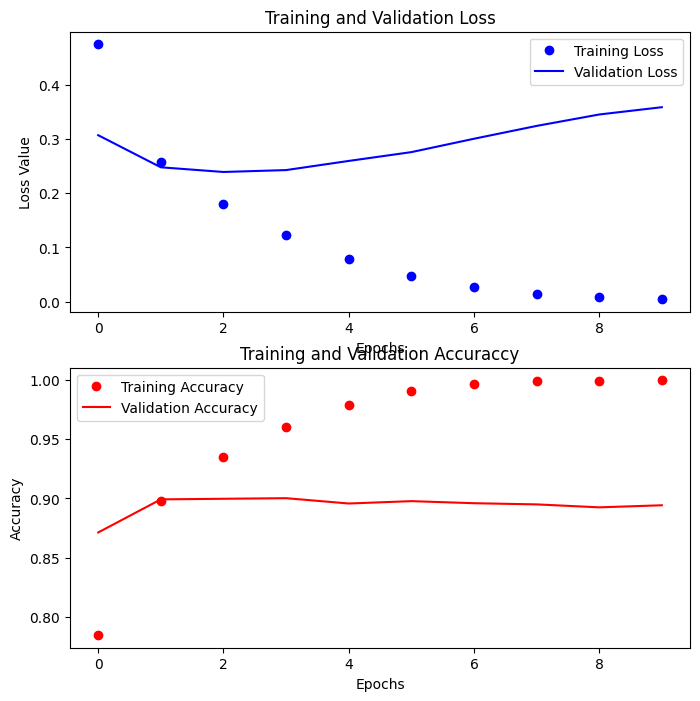

In [ ]:
# learning curves
history_dict = history.history
history_dict.keys()

# losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# accuracies
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

epochs = range(NUM_EPOCHS)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(epochs, loss_values, 'bo', label="Training Loss")
ax1.plot(epochs, val_loss_values, 'b', label="Validation Loss")
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss Value')
ax1.legend()

ax2.plot(epochs, acc_values, 'ro', label="Training Accuracy")
ax2.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
ax2.set_title('Training and Validation Accuraccy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
y_pred = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
y_pred = [ round(y[0]) for y in y_pred ]

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[4358,  554],
       [ 533, 4555]])